# **STEP 0: IMPORT LIBRARIES**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer  
from sklearn.preprocessing import OneHotEncoder      
from sklearn.model_selection import KFold   
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from statistics import mean
from sklearn.model_selection import train_test_split
import joblib 
import lightgbm as lgb
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit, StratifiedKFold, StratifiedShuffleSplit
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold, StratifiedKFold

# Additional useful imports
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import learning_curve
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, median_absolute_error
import seaborn as sns
from scipy import stats
import warnings
import os
import yfinance as yf
import ta

# **STEP 1: DEFINE LABEL**

In [2]:
forex_label = ['USDCAD=X'] # You can update by adding more

# **STEP 2: GET FOREX DATA CRAWLING**

**2.1: Crawl all FOREX data needed**

**2.1.1. Function to crawl Forex data**

In [3]:
def crawl_forex_data(forex_pair, directory='Dataset'):
    """
    Crawls historical data for a given Forex pair and saves it to a CSV file.

    Parameters:
    forex_pair (str): The Forex pair symbol to download data for (e.g., 'EURUSD=X').
    directory (str): The directory where the data should be saved.

    Returns:
    str: Path to the saved CSV file.
    pd.DataFrame: The crawled data as a Pandas DataFrame.
    """
    # Create directory if it doesn't exist
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Download historical data for the Forex pair
    print(f"Downloading data for {forex_pair}...")
    data = yf.download(forex_pair, period="max", interval='1d')
    data.reset_index(inplace=True)  # Reset index to ensure 'Date' is a normal column

    # Save data to CSV
    file_path = os.path.join(directory, f'{forex_pair}_data.csv')
    data.to_csv(file_path, index=False)
    print(f"Saved data for {forex_pair} at {file_path}")

    return file_path, data

**2.2. Check crawling result**

In [4]:
file_path, data = crawl_forex_data(forex_label)

# Display the first 10 rows of the DataFrame
print(data.head(5))
print(data.info())

# Calculate and print statistics of NaN values
nan_stats = data.isna().sum()
total_nans = nan_stats.sum()

print("\nStatistics of NaN values in the DataFrame:")
print(nan_stats)
print(f"\nTotal number of NaN values: {total_nans}")

[*********************100%***********************]  1 of 1 completed

Saved data for ['USDCAD=X'] at Dataset\['USDCAD=X']_data.csv
        Date    Open    High     Low   Close  Adj Close  Volume
0 2003-09-17  1.3667  1.3704  1.3636  1.3667     1.3667       0
1 2003-09-18  1.3660  1.3685  1.3597  1.3615     1.3615       0
2 2003-09-19  1.3620  1.3630  1.3457  1.3472     1.3472       0
3 2003-09-22  1.3413  1.3553  1.3365  1.3542     1.3542       0
4 2003-09-23  1.3549  1.3577  1.3458  1.3551     1.3551       0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5476 entries, 0 to 5475
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       5476 non-null   datetime64[ns]
 1   Open       5476 non-null   float64       
 2   High       5476 non-null   float64       
 3   Low        5476 non-null   float64       
 4   Close      5476 non-null   float64       
 5   Adj Close  5476 non-null   float64       
 6   Volume     5476 non-null   int64         
dtypes: datetime64[ns](1),

**STEP 3: FEATURE ENGINEERING**

In [5]:
# Feature Engineering 
# Calculate moving averages
if 'Close' in data.columns:
    if len(data) >= 10: data['MA_10'] = data['Close'].rolling(window=10).mean()
    if len(data) >= 50: data['MA_50'] = data['Close'].rolling(window=50).mean()
    if len(data) >= 200: data['MA_200'] = data['Close'].rolling(window=200).mean()

# Calculate RSI
data['RSI'] = ta.momentum.RSIIndicator(data['Close'], window=14).rsi()

# Calculate MACD
data['MACD'] = ta.trend.MACD(data['Close']).macd()

# Calculate Bollinger Bands
bollinger = ta.volatility.BollingerBands(data['Close'])
data['BB_High'] = bollinger.bollinger_hband()
data['BB_Low'] = bollinger.bollinger_lband()

# Calculate Bollinger BandWidth (BBTrend)
data['BB_Width'] = (data['BB_High'] - data['BB_Low']) / data['Close']

# 24-hour Volume
data['Volume_24h'] = data['Volume'].rolling(window=1440).sum()

# Accumulation/Distribution Line (ADL)
data['ADL'] = ta.volume.AccDistIndexIndicator(data['High'], data['Low'], data['Close'], data['Volume']).acc_dist_index()

# Aroon Indicator
aroon = ta.trend.AroonIndicator(data['Close'], data['Low'], window=25)
data['Aroon_Up'] = aroon.aroon_up()
data['Aroon_Down'] = aroon.aroon_down()

# Average Directional Index (ADX)
data['ADX'] = ta.trend.ADXIndicator(data['High'], data['Low'], data['Close'], window=14).adx()

# Average True Range (ATR)
data['ATR'] = ta.volatility.AverageTrueRange(data['High'], data['Low'], data['Close'], window=14).average_true_range()

# Awesome Oscillator (AO)
data['AO'] = ta.momentum.AwesomeOscillatorIndicator(data['High'], data['Low'], window1=5, window2=34).awesome_oscillator()

# Balance of Power (BOP)
data['BOP'] = (data['Close'] - data['Open']) / (data['High'] - data['Low'])

# Bull Bear Power
data['Bull_Power'] = data['High'] - data['MA_50']
data['Bear_Power'] = data['Low'] - data['MA_50']

# Chaikin Oscillator
data['Chaikin_Osc'] = data['ADL'].ewm(span=3).mean() - data['ADL'].ewm(span=10).mean()

# Stochastic Oscillator (Stoch)
stoch = ta.momentum.StochasticOscillator(data['High'], data['Low'], data['Close'], window=14)
data['Stoch_Osc'] = stoch.stoch()

# Commodity Channel Index (CCI)
data['CCI'] = ta.trend.CCIIndicator(data['High'], data['Low'], data['Close'], window=20).cci()

# Vortex Oscillator
vortex = ta.trend.VortexIndicator(data['High'], data['Low'], data['Close'], window=14)
data['Vortex_Plus'] = vortex.vortex_indicator_pos()
data['Vortex_Minus'] = vortex.vortex_indicator_neg()

**3.2. Check NaN values before interpolation**

In [6]:
nan_stats_before = data.isna().sum()
total_nans_before = nan_stats_before.sum()
print("\nStatistics of NaN values before interpolation:")
print(nan_stats_before)
print(f"Total number of NaN values before interpolation: {total_nans_before}")


Statistics of NaN values before interpolation:
Date               0
Open               0
High               0
Low                0
Close              0
Adj Close          0
Volume             0
MA_10              9
MA_50             49
MA_200           199
RSI               13
MACD              25
BB_High           19
BB_Low            19
BB_Width          19
Volume_24h      1439
ADL                0
Aroon_Up          25
Aroon_Down        25
ADX                0
ATR                0
AO                33
BOP                3
Bull_Power        49
Bear_Power        49
Chaikin_Osc        0
Stoch_Osc         13
CCI               19
Vortex_Plus       14
Vortex_Minus      14
dtype: int64
Total number of NaN values before interpolation: 2035


**3.3. Use Interpolation to fill missing values**

**Why use Interpolation ?**

In [7]:
# Interpolate missing data
data.interpolate(method='linear', inplace=True)

In [8]:
# Check how many rows remain after interpolation
nan_stats_after = data.isna().sum()
total_nans_after = nan_stats_after.sum()
print("\nStatistics of NaN values after interpolation:")
# print(nan_stats_after)
print(f"Total number of NaN values after interpolation: {total_nans_after}")


Statistics of NaN values after interpolation:
Total number of NaN values after interpolation: 2032


**NOTE: As we can see, after using the interpolation, there are still many NaN values**

**3.4: Detect NaN values left and fill them**

In [9]:
# If there are still NaN values, use another method to fill them
if total_nans_after > 0:
    # Fill remaining NaN values with forward fill
    data.fillna(method='ffill', inplace=True)
    
    # If still NaN, use backward fill
    if data.isna().sum().sum() > 0:
        data.fillna(method='bfill', inplace=True)

C:\Users\Admin\AppData\Local\Temp\ipykernel_10944\1693104163.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_10944\1693104163.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)


**3.5. Examine for left over NaN result**

In [10]:
# Final check on NaN values
nan_stats_final = data.isna().sum()
total_nans_final = nan_stats_final.sum()
print("\n----Statistics of NaN values after final filling----")
print(f"Total number of NaN values after final filling: {total_nans_final}")

# Check how many rows remain after dropping NaN values
data.dropna(subset=['Close', 'Open'], inplace=True)
print(f"Number of rows after dropna: {len(data)}")


----Statistics of NaN values after final filling----
Total number of NaN values after final filling: 0
Number of rows after dropna: 5476


**3.6. Define list of indicators**

In [11]:
# List of indicators to plot
indicators = [
    'MA_10', 'MA_50', 'MA_200',
    'RSI', 'MACD',
    'BB_High', 'BB_Low',
    'ADX', 'ATR', 'AO',
    'BOP', 'Bull_Power', 'Bear_Power',
    'Chaikin_Osc',
    'Stoch_Osc', 'CCI',
    'Vortex_Plus', 'Vortex_Minus'
    ]

**STEP 4: PLOTTING FOR EVALUATION**

**Function to plot year data**

In [12]:
def plot_yearly_data(data, title='Yearly Price Data'):
    plt.figure(figsize=(14, 7))
    plt.plot(data['Date'], data['Close'], label='Close Price', color='blue')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    plt.show()

**Functions to plot prices vs indicators**

In [13]:
def plot_prices_vs_indicators(data, indicator, title):
    plt.figure(figsize=(14, 7))
    plt.plot(data['Date'], data['Close'], label='Close Price', color='blue')
    plt.plot(data['Date'], data[indicator], label=indicator, color='orange')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price / Indicator Value')
    plt.legend()
    plt.grid()
    plt.show()

**Function to plot out Label Price vs other forex pairs**

In [14]:
# **Function to plot out Label Price vs Other Forex Pairs**
def plot_label_vs_other_forex(data, label, other_pairs):
    plt.figure(figsize=(14, 7))
    
    # Check if the label exists in the DataFrame
    if label not in data.columns:
        print(f"Label '{label}' not found in DataFrame columns: {data.columns}")
        return

    plt.plot(data['Date'], data[label], label=label, color='blue')
    
    for pair in other_pairs:
        pair_close = f'{pair}_Close'
        if pair_close in data.columns:  # Ensure the pair exists in the DataFrame
            plt.plot(data['Date'], data[pair_close], label=f'{pair} Close', linestyle='--')
    
    plt.title(f'{label} vs Other Forex Pairs')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    plt.show()

**4.1. Plot out yearly data**

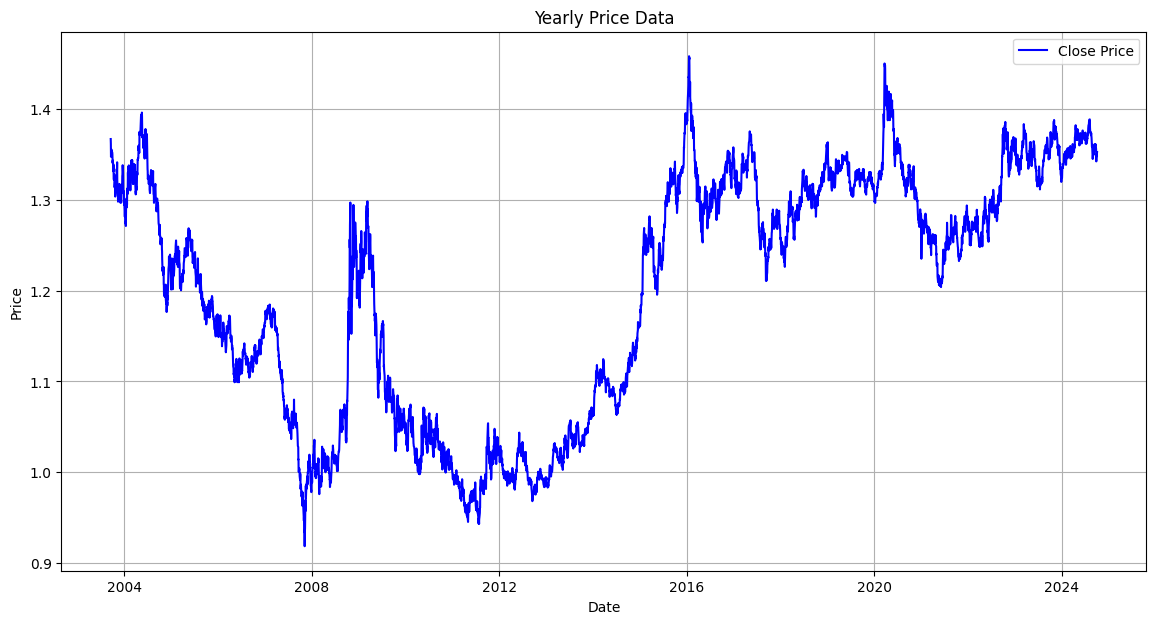

In [15]:
# Plot yearly data
plot_yearly_data(data)

**4..2. Plot out indicators vs price**

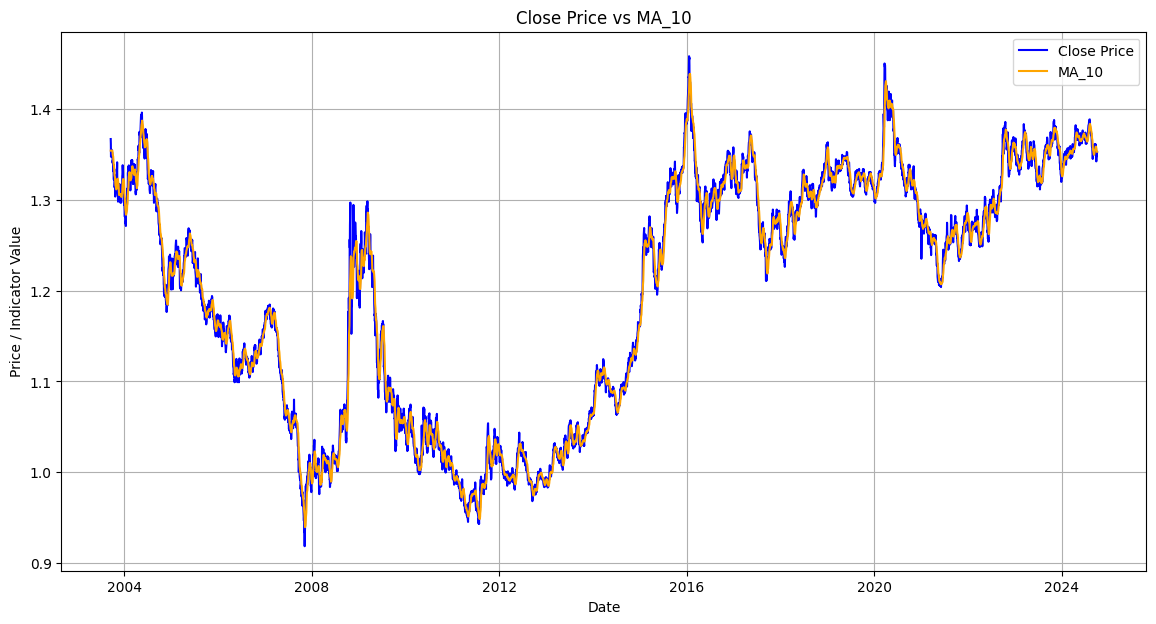

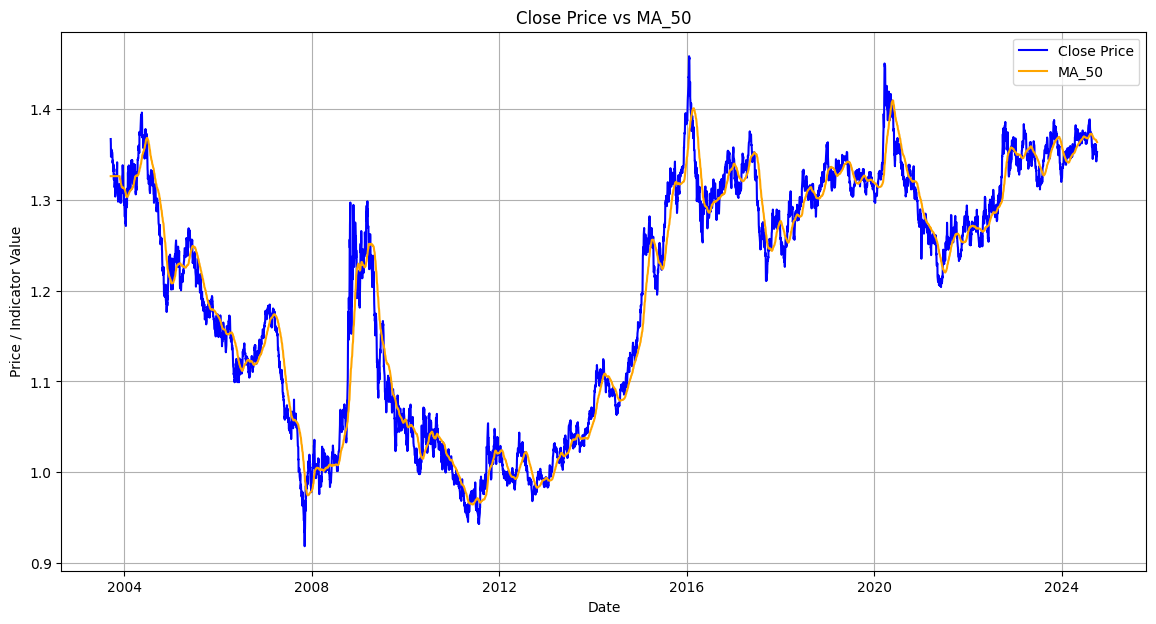

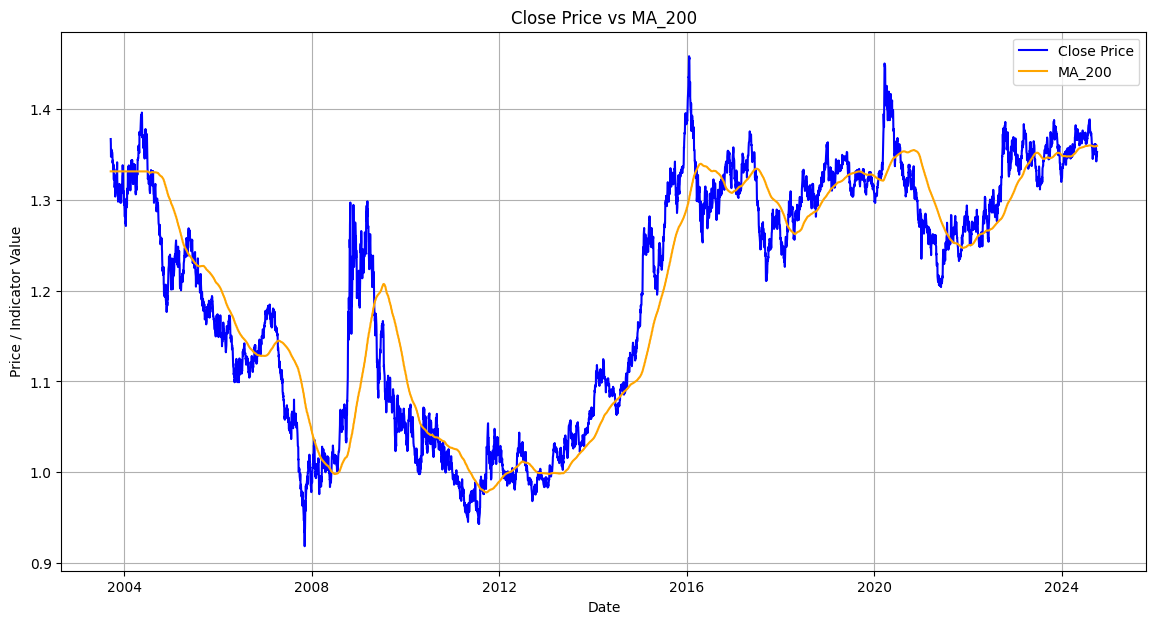

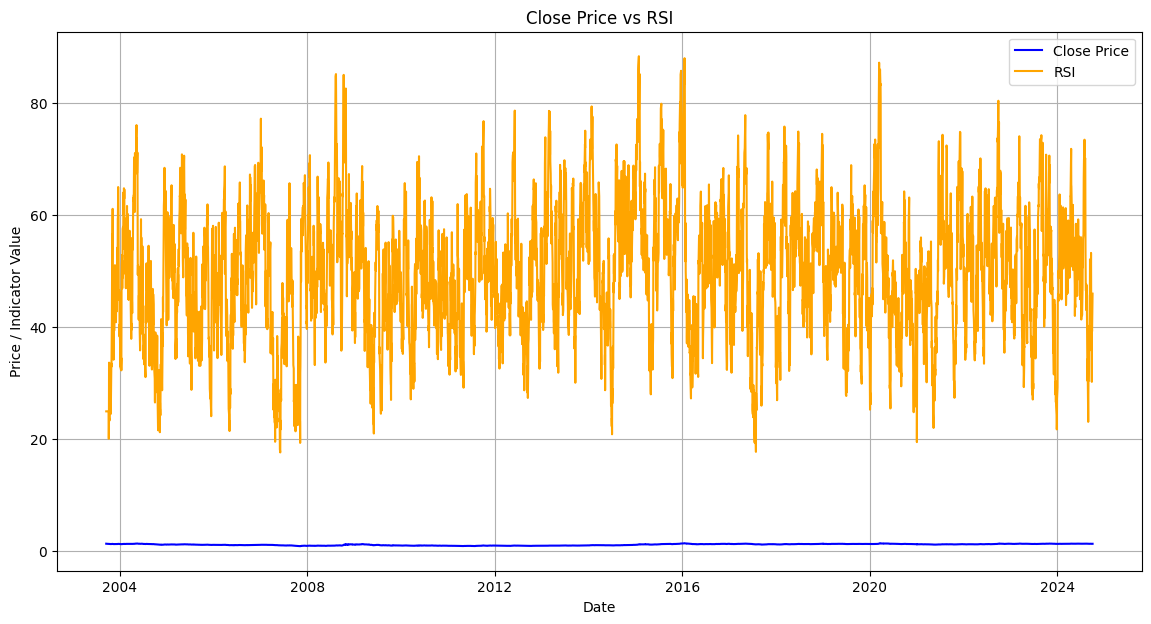

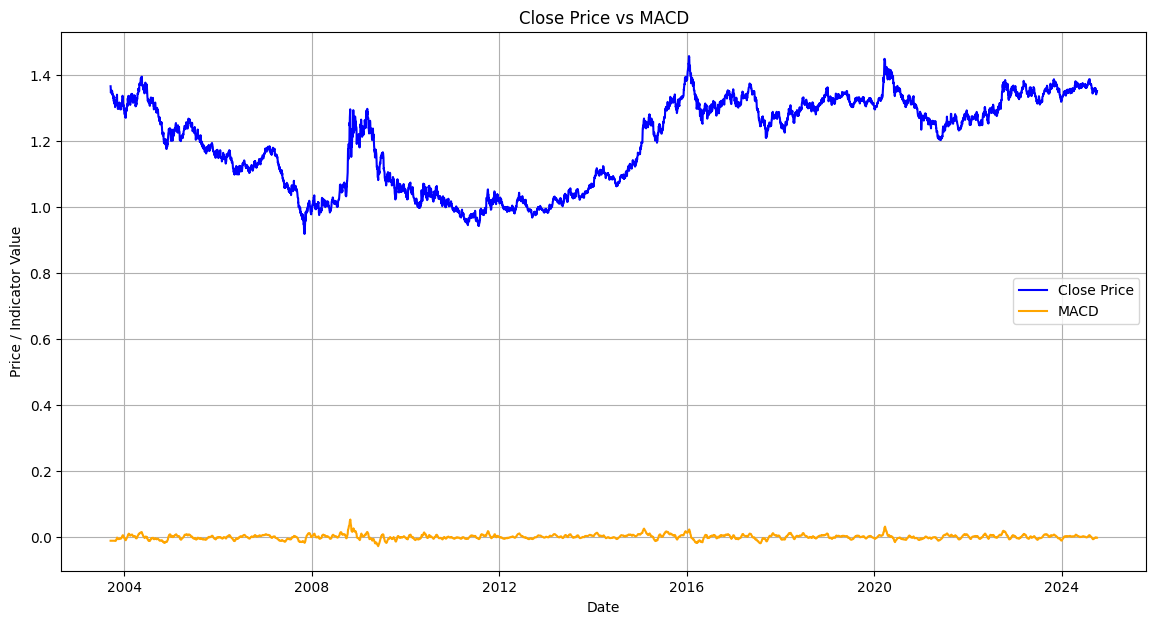

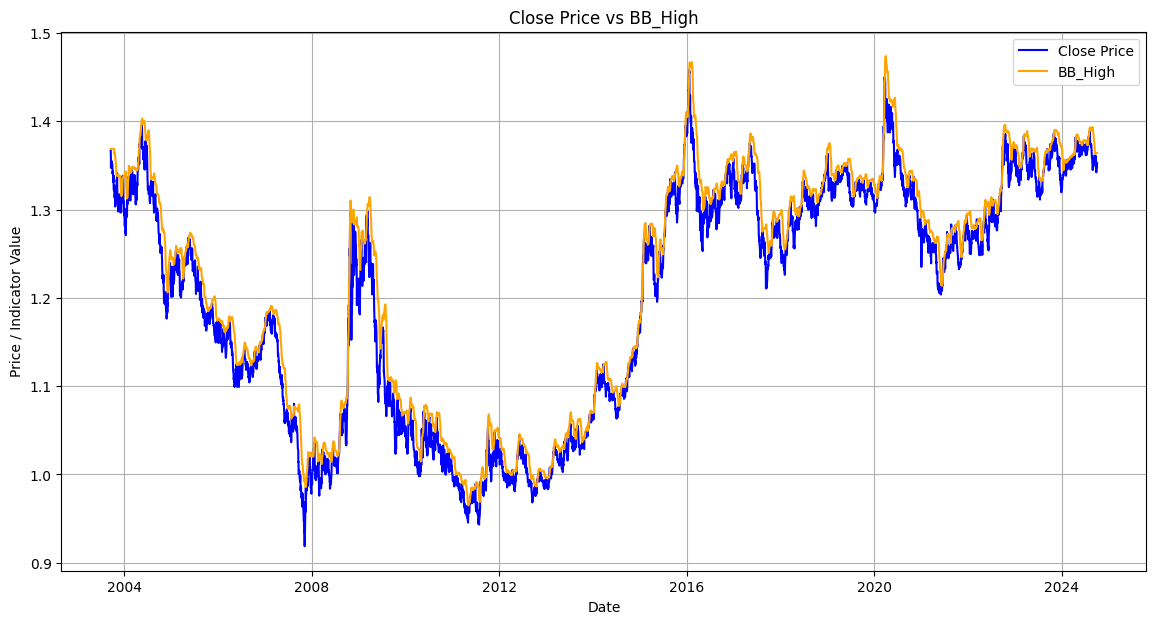

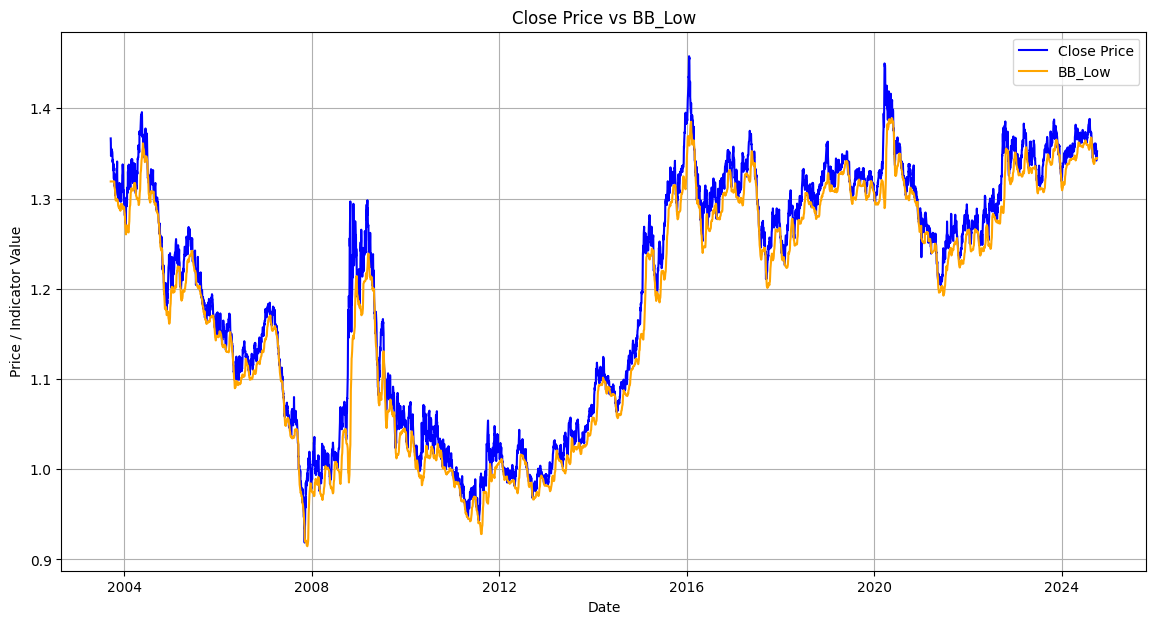

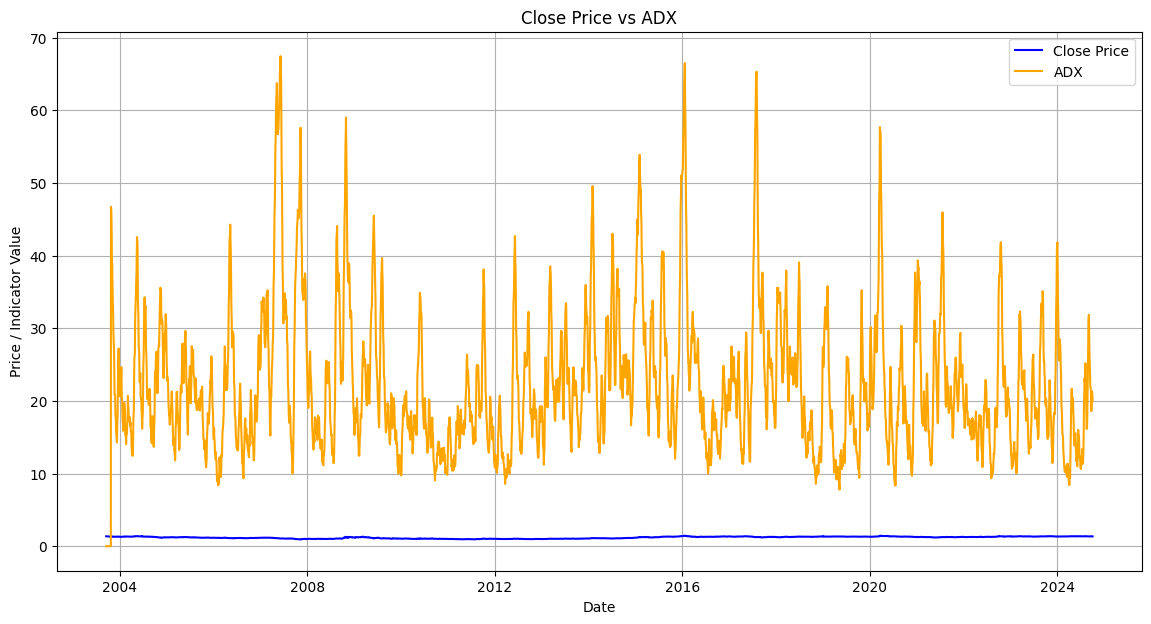

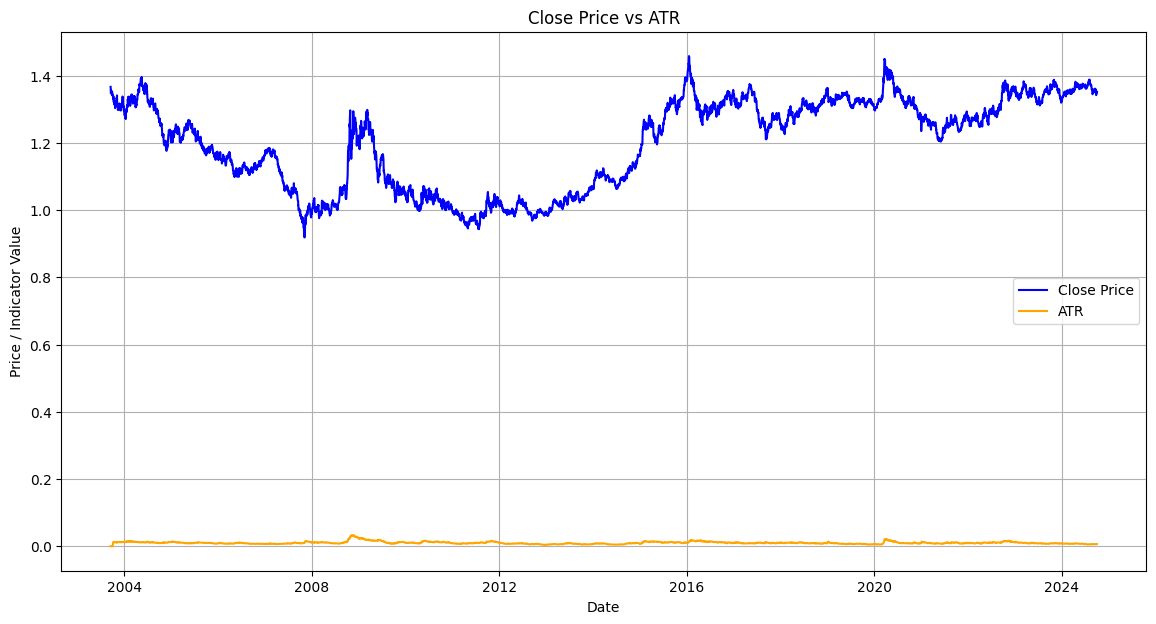

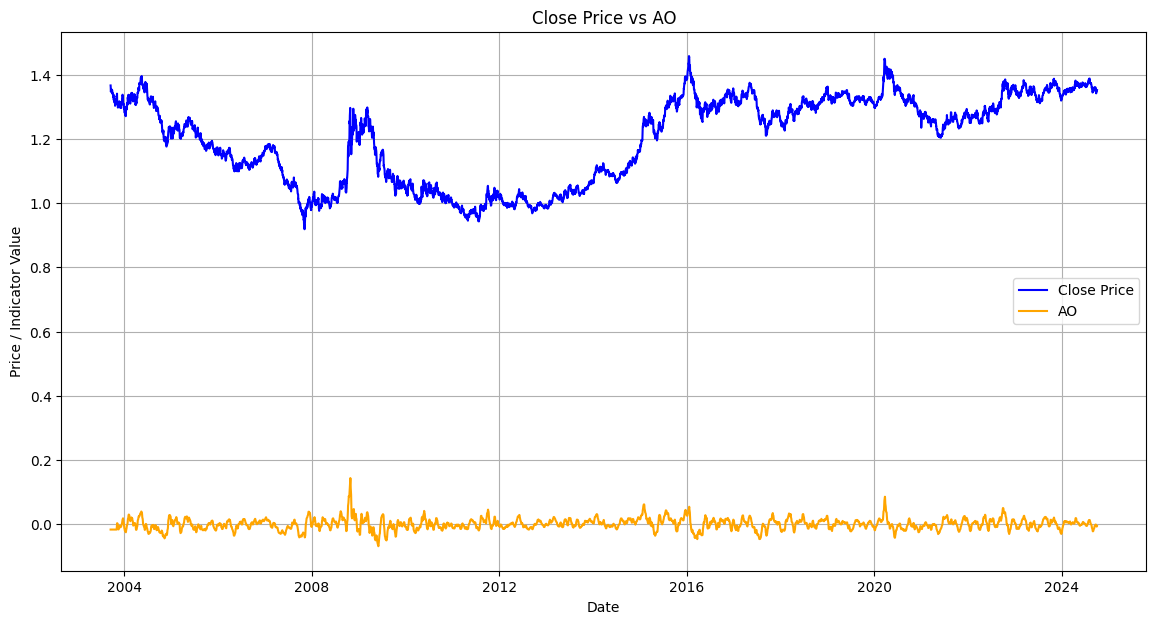

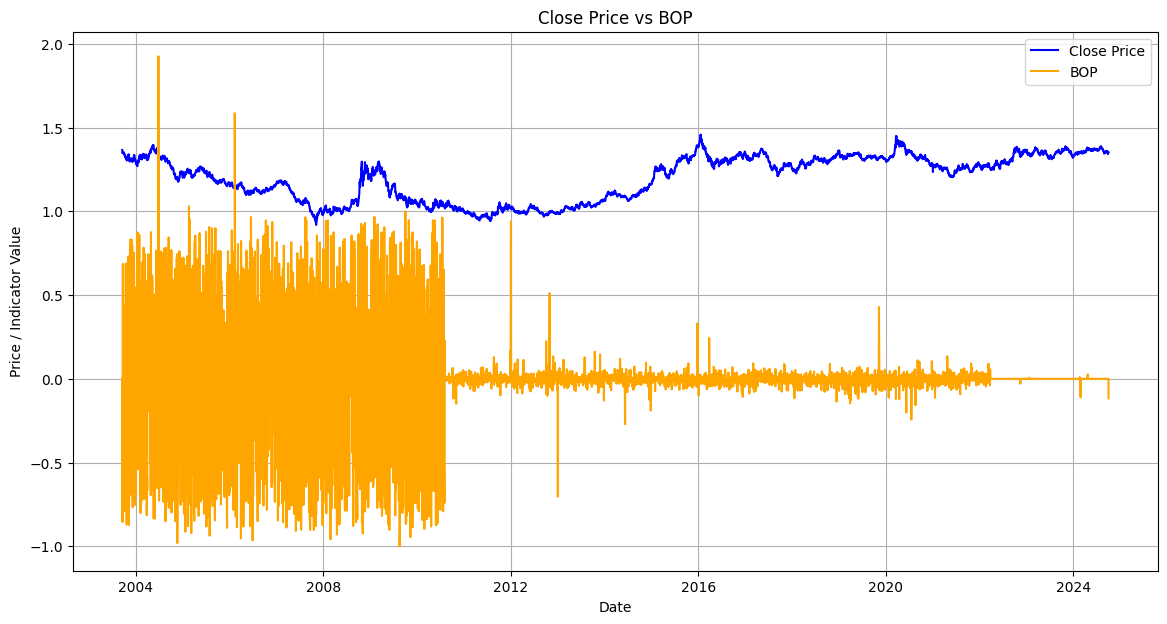

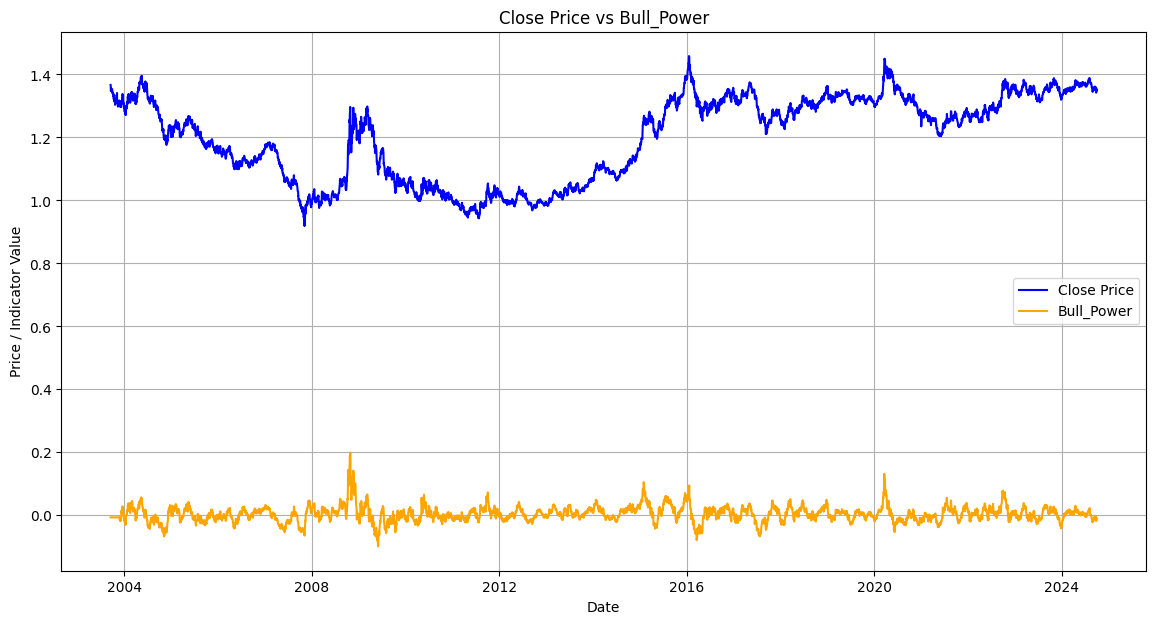

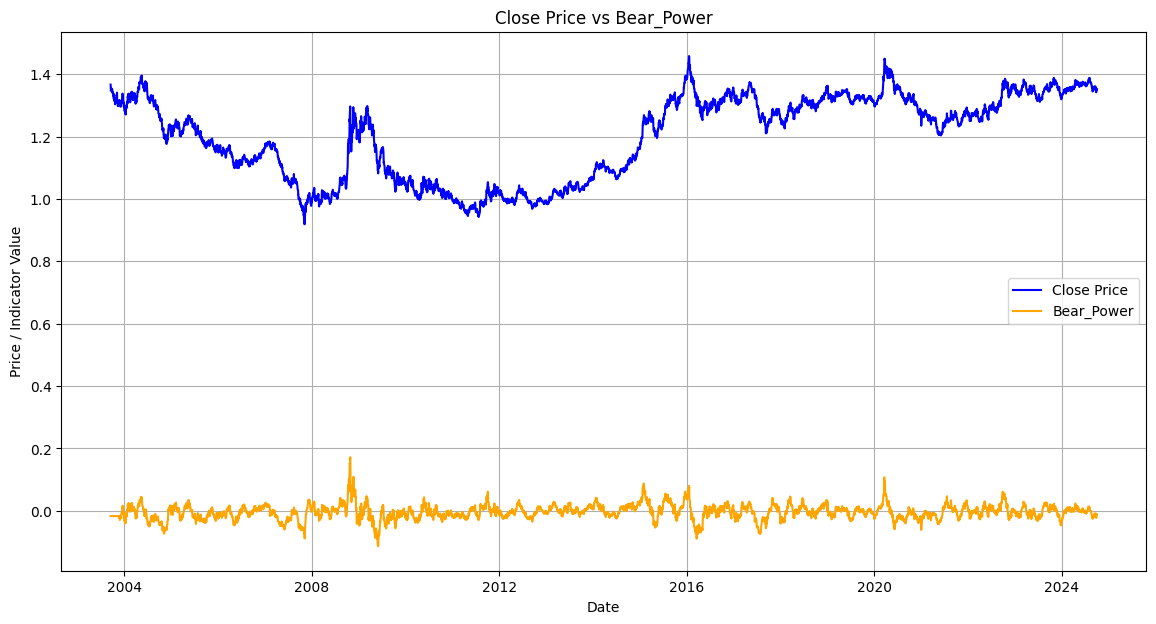

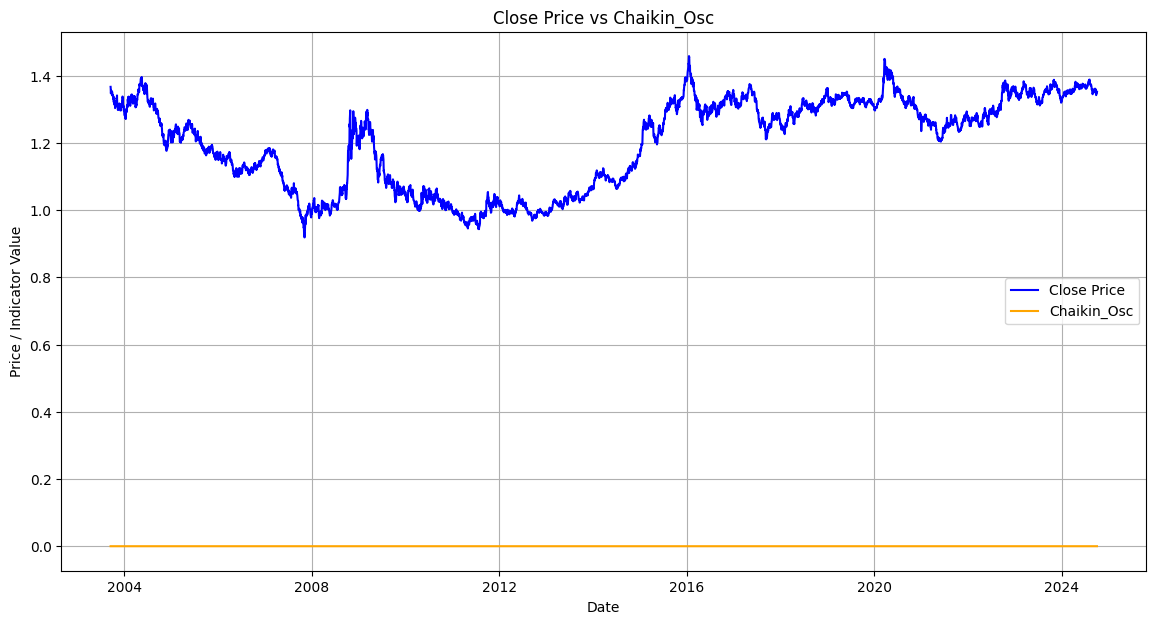

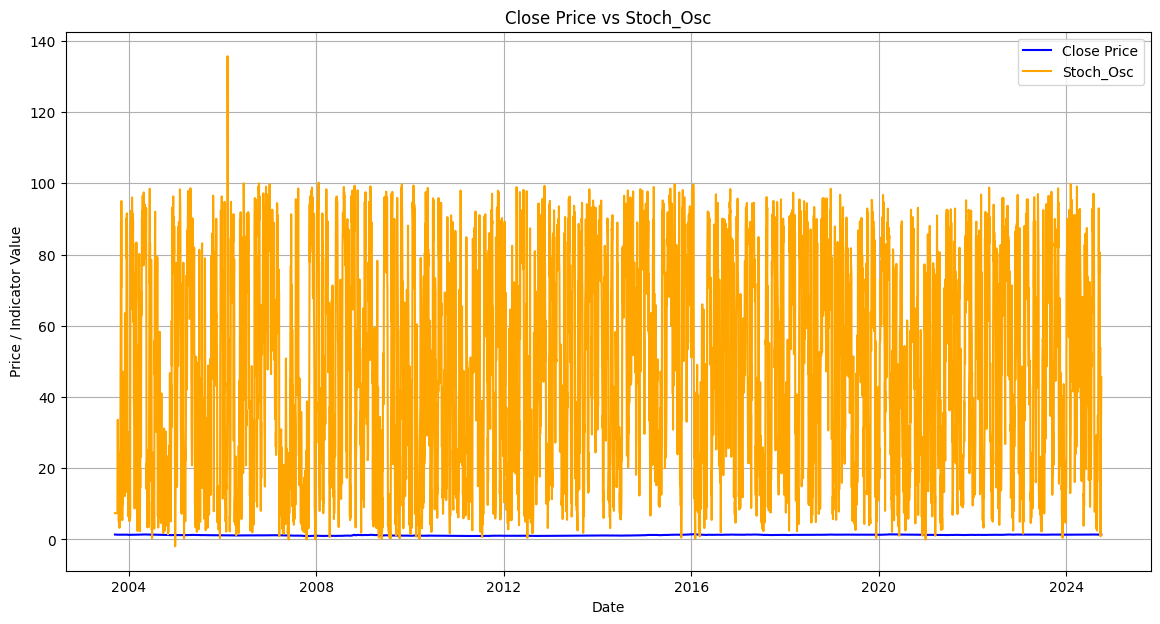

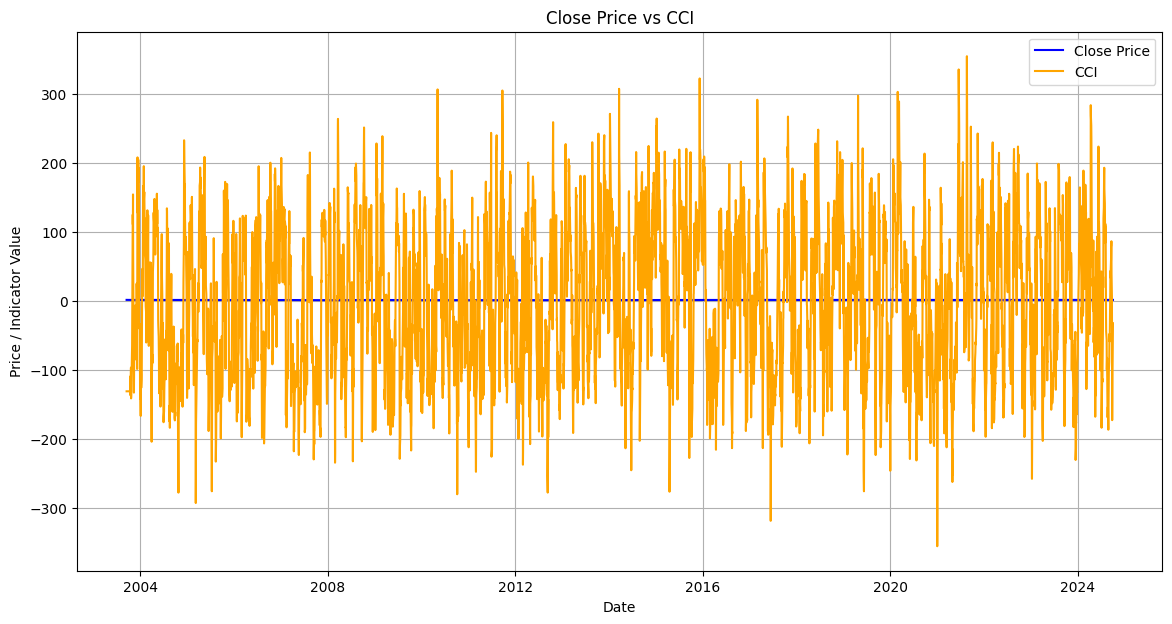

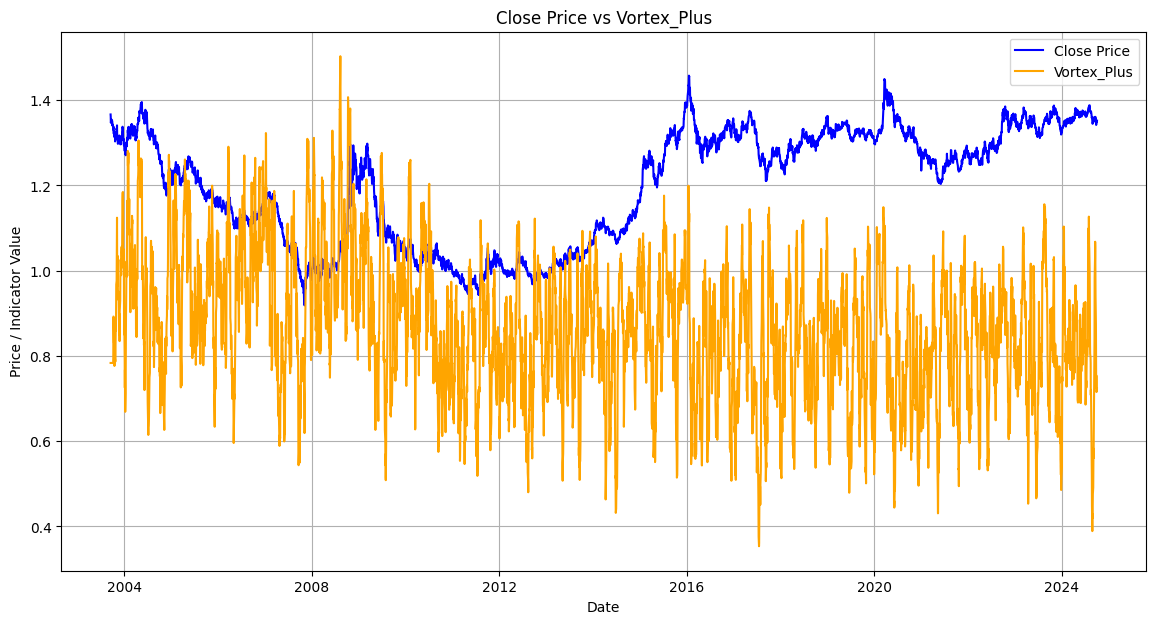

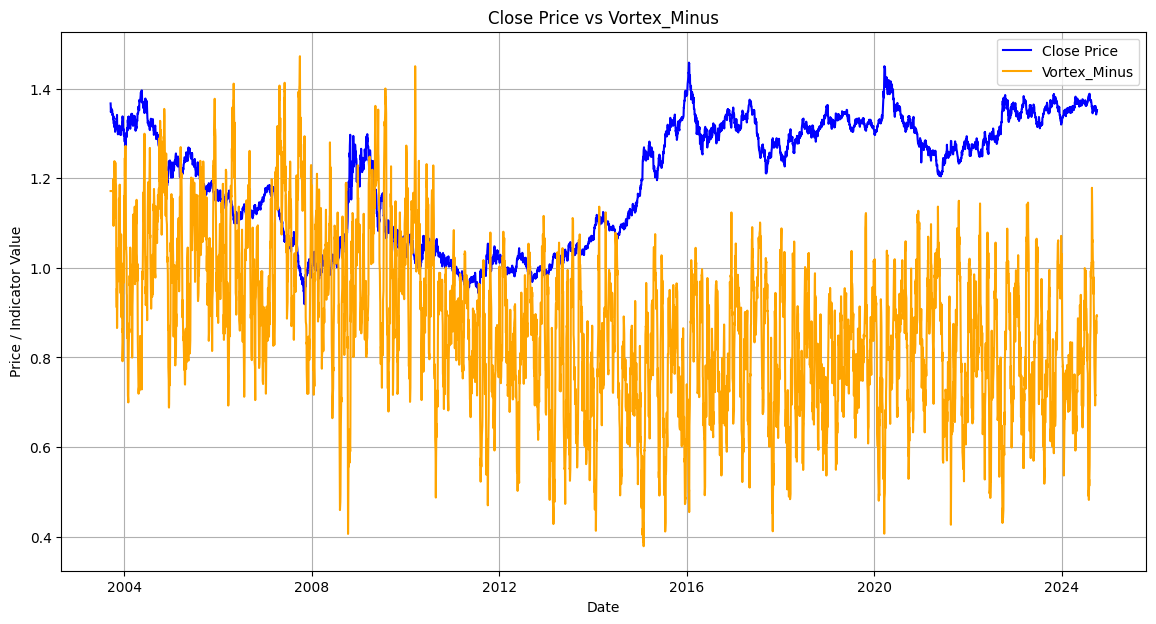

In [16]:
# Plot Close Price vs each indicator
for indicator in indicators:
    if indicator in data.columns:  # Check if the indicator exists
        plot_prices_vs_indicators(data, indicator, f'Close Price vs {indicator}')

# **STEP 5 FIND UN-RELATED FEATURES USING MUTUAL INFORMATION (MI)**

**5.1. Calculate MI and decide which feature has the highest correlation**

In [17]:
# Define the target variables
targets = ['Close', 'Open', 'High', 'Low']  # Add any other targets you want to consider

# Initialize a DataFrame to hold MI scores for each target
mi_results = pd.DataFrame()

# Separate features
X = data.drop(columns=['Date'] + targets)  # Exclude the target and date columns

# Calculate Mutual Information for each target variable
for target in targets:
    y = data[target]
    
    # Calculate Mutual Information
    mi_scores = mutual_info_regression(X, y)
    
    # Create a DataFrame for the current target's MI scores
    mi_df = pd.DataFrame(mi_scores, index=X.columns, columns=[f'MI Score_{target}'])
    
    # Append to the results DataFrame
    mi_results = pd.concat([mi_results, mi_df], axis=1)

# Set display options to avoid scientific notation
pd.set_option('display.float_format', '{:.6f}'.format)

# Display the MI scores for all targets
print("Mutual Information Scores for each target:")
print(mi_results)

Mutual Information Scores for each target:
              MI Score_Close  MI Score_Open  MI Score_High  MI Score_Low
Adj Close           7.278954       4.871308       3.538880      3.564771
Volume              0.000025       0.000024       0.000001      0.000000
MA_10               2.338751       2.396372       2.311428      2.363748
MA_50               1.789730       1.801194       1.810532      1.824263
MA_200              1.593707       1.582024       1.630248      1.659284
RSI                 0.212425       0.169971       0.165591      0.158050
MACD                0.317980       0.313435       0.309200      0.317282
BB_High             2.064839       2.083949       2.046361      2.064061
BB_Low              2.073866       2.101546       2.069762      2.105662
BB_Width            0.257527       0.252820       0.267914      0.282158
Volume_24h          0.000000       0.000031       0.000001      0.000000
ADL                 0.000045       0.000000       0.000000      0.000000
Aroon_Up

**5.2. Drop unrelated features**

In [18]:
# Define a threshold for MI score
mi_threshold = 0.25

# Identify features to drop based on the MI score for each target
features_to_drop = set()
for target in targets:
    low_mi_features = mi_results[mi_results[f'MI Score_{target}'] < mi_threshold].index.tolist()
    features_to_drop.update(low_mi_features)

# Drop the unrelated features from the DataFrame
X_reduced = X.drop(columns=list(features_to_drop))

# Optionally, update the DataFrame with the target
data_reduced = data.drop(columns=list(features_to_drop))

# Check the remaining features
print("Remaining features after dropping unrelated ones:")
print(X_reduced.columns)

# Save the reduced DataFrame if needed
reduced_file_path = os.path.join('Dataset', forex_label[0] + '_reduced_data.csv')
data_reduced.to_csv(reduced_file_path, index=False)
print(f"Saved reduced data to: {reduced_file_path}")
print(data.head(1000))

Remaining features after dropping unrelated ones:
Index(['Adj Close', 'MA_10', 'MA_50', 'MA_200', 'MACD', 'BB_High', 'BB_Low',
       'BB_Width', 'ATR', 'Bull_Power', 'Bear_Power'],
      dtype='object')
Saved reduced data to: Dataset\USDCAD=X_reduced_data.csv
          Date     Open     High      Low    Close  Adj Close  Volume  \
0   2003-09-17 1.366700 1.370400 1.363600 1.366700   1.366700       0   
1   2003-09-18 1.366000 1.368500 1.359700 1.361500   1.361500       0   
2   2003-09-19 1.362000 1.363000 1.345700 1.347200   1.347200       0   
3   2003-09-22 1.341300 1.355300 1.336500 1.354200   1.354200       0   
4   2003-09-23 1.354900 1.357700 1.345800 1.355100   1.355100       0   
..         ...      ...      ...      ...      ...        ...     ...   
995 2007-07-13 1.045400 1.049400 1.044600 1.047100   1.047100       0   
996 2007-07-16 1.047600 1.048000 1.041600 1.043700   1.043700       0   
997 2007-07-17 1.043740 1.044960 1.042000 1.043250   1.043250       0   
998 2007-

# **STEP 6: PREPARE AND TRANSFORM DATA-FRAME**

In [19]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names):
        self.feature_names = feature_names

    def fit(self, dataframe, labels=None):
        return self

    def transform(self, dataframe):
        return dataframe[self.feature_names].values

**6.1. Shift Label for future predictions**

In [20]:
k = -1
for target_column in targets:  # Iterate over each target
    data[target_column] = data[target_column].shift(k)

# Drop rows with NaN values created by the shift
data = data.dropna()

# Print some data 
print(data.head())

        Date     Open     High      Low    Close  Adj Close  Volume    MA_10  \
0 2003-09-17 1.366000 1.368500 1.359700 1.361500   1.366700       0 1.353920   
1 2003-09-18 1.362000 1.363000 1.345700 1.347200   1.361500       0 1.353920   
2 2003-09-19 1.341300 1.355300 1.336500 1.354200   1.347200       0 1.353920   
3 2003-09-22 1.354900 1.357700 1.345800 1.355100   1.354200       0 1.353920   
4 2003-09-23 1.354800 1.359500 1.348300 1.350100   1.355100       0 1.353920   

     MA_50   MA_200  ...      ATR        AO       BOP  Bull_Power  Bear_Power  \
0 1.325848 1.331133  ... 0.000000 -0.017105  0.000000   -0.006348   -0.017148   
1 1.325848 1.331133  ... 0.000000 -0.017105 -0.511365   -0.006348   -0.017148   
2 1.325848 1.331133  ... 0.000000 -0.017105 -0.855488   -0.006348   -0.017148   
3 1.325848 1.331133  ... 0.000000 -0.017105  0.686174   -0.006348   -0.017148   
4 1.325848 1.331133  ... 0.000000 -0.017105  0.016810   -0.006348   -0.017148   

   Chaikin_Osc  Stoch_Osc       

**6.2. Split the data into training and test sets**

In [21]:
train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)

# Print out some information about the split
print('\n____________ Split training and test set ____________')     
print(len(train_set), "training +", len(test_set), "test examples")
print(train_set.head(4))


____________ Split training and test set ____________
4380 training + 1095 test examples
           Date     Open     High      Low    Close  Adj Close  Volume  \
5238 2023-11-03 1.366060 1.368330 1.362900 1.366060   1.374700       0   
1034 2007-09-06 1.051600 1.056700 1.048200 1.054400   1.051500       0   
3515 2017-03-23 1.334890 1.338340 1.334600 1.334850   1.333200       0   
931  2007-04-16 1.132410 1.133900 1.128600 1.131300   1.132310       0   

        MA_10    MA_50   MA_200  ...      ATR        AO       BOP  Bull_Power  \
5238 1.379000 1.362751 1.348716  ... 0.008887  0.016436  0.000000    0.013219   
1034 1.055240 1.054820 1.117094  ... 0.009515 -0.003211 -0.280246    0.002980   
3515 1.338681 1.321608 1.318684  ... 0.008393  0.008811 -0.073059    0.013762   
931  1.146246 1.163820 1.144851  ... 0.006655 -0.022165 -0.613836   -0.027420   

      Bear_Power  Chaikin_Osc  Stoch_Osc         CCI  Vortex_Plus  \
5238    0.003839     0.000000  48.649473    4.749885     0.84983

**6.3. Define features and targets**

In [22]:
feature_columns = data.columns.difference(['Date'] + targets).tolist()  # Define features excluding Date and targets
X_reduced = data.drop(columns=['Date'] + targets).drop(columns=list(features_to_drop))  

In [23]:
X_train = train_set[X_reduced.columns]
X_test = test_set[X_reduced.columns]

# Split targets for each label
y_train_dict = {target: train_set[target] for target in targets}
y_test_dict = {target: test_set[target] for target in targets}

**6.4. Define and Train Model Pipelines for Each Target**

In [24]:

# Redefine num_feat_names based on X_reduced
num_feat_names = X_reduced.columns.tolist()

In [25]:
num_pipeline = Pipeline(steps=[
    ('selector', ColumnSelector(num_feat_names)),
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('scaler', StandardScaler(with_mean=True, with_std=True))
])


**6.4.2. Fit and Transform the Pipeline on training data**

In [26]:

# Run the pipeline to process training data
processed_train_set_val = num_pipeline.fit_transform(X_train)

# Fit the pipeline on training data and transform both training and test data
X_train = num_pipeline.fit_transform(X_train)
X_test = num_pipeline.transform(X_test)

# Convert the transformed data back to DataFrame with appropriate column names
X_train = pd.DataFrame(X_train, columns=num_feat_names)
X_test = pd.DataFrame(X_test, columns=num_feat_names)

print('\n____________ Processed feature values ____________')
print(processed_train_set_val[:3, :])  # Print out some of the first rows of the training dataset after fit_transforming
print(processed_train_set_val.shape)  # Print out the statistics of the training set

# Save the numerical pipeline
joblib.dump(num_pipeline, r'models/num_pipeline.pkl')


____________ Processed feature values ____________
[[ 1.30390214  1.33897143  1.22940022  1.1620529   0.93448775  1.26198155
   1.30353514 -0.36053408 -0.32703569  0.35594898  0.33897339]
 [-1.11322698 -1.08681297 -1.0990683  -0.64198271 -0.18240959 -1.08607325
  -1.03156007 -0.22790468 -0.14941172 -0.0607016   0.01518313]
 [ 0.99353458  1.03687965  0.91829028  0.92814381  0.59224977  1.01504405
   1.00124323 -0.04040714 -0.46666357  0.37805251  0.59133575]]
(4380, 11)


['models/num_pipeline.pkl']

# **STEP 7. TRAIN AND EVALUATE MODEL**

**Function to calculate R2 score and Root Mean Squared Error.**

In [27]:
def r2score_and_rmse(model, train_data, labels): 
    r2score = model.score(train_data, labels)
    from sklearn.metrics import mean_squared_error
    prediction = model.predict(train_data)
    mse = mean_squared_error(labels, prediction)
    rmse = np.sqrt(mse)
    return r2score, rmse

**Function to Store and Load Models.**

In [28]:
def store_model(model, model_name = ""):
    # NOTE: sklearn.joblib faster than pickle of Python
    # INFO: can store only ONE object in a file
    if model_name == "": 
        model_name = type(model).__name__
    joblib.dump(model,'models/' + model_name + '_model.pkl')
    print(f"Model successfully saved as " + model_name + '_model.pkl')
    
def load_model(model_name):
    # Load objects into memory
    #del model
    model = joblib.load('models/' + model_name + '_model.pkl')
    #print(model)
    return model

**7.1. Try Light GBM model.**

In [29]:
for target in targets:
    model = lgb.LGBMRegressor()  # Initialize the model
    model.fit(X_train, y_train_dict[target])  # Fit the model on the respective target

    print(f'\n____________ LGBMRegressor for {target} ____________')

    r2score, rmse = r2score_and_rmse(model, X_train, y_train_dict[target])
    print('\nR2 score (on training data, best=1):', r2score)
    print("Root Mean Square Error: ", rmse)

    # Predict labels for some test instances
    print("\nPredictions: ", model.predict(X_test[:9]))
    print("Labels:      ", list(y_test_dict[target][:9]))

    store_model(model)  # Store the model for the current target

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 4380, number of used features: 11
[LightGBM] [Info] Start training from score 1.200226

____________ LGBMRegressor for Close ____________

R2 score (on training data, best=1): 0.9987182081991124
Root Mean Square Error:  0.004785098216677529

Predictions:  [1.36733001 1.35395569 0.97488466 1.15893728 1.37973136 1.04011428
 1.30762887 1.38681946 1.33388678]
Labels:       [1.3630000352859497, 1.3643800020217896, 0.9837999939918518, 1.1672999858856201, 1.3821899890899658, 1.0409300327301025, 1.3022300004959106, 1.3914999961853027, 1.3308000564575195]
Model successfully saved as LGBMRegressor_model.pkl
[LightGBM] [Warning] Found whitespace in feature_names, repla

**7.2. Try XGBoost model.**

In [30]:
for target in targets:
    model = XGBRegressor() # Initialize the model
    model.fit(X_train, y_train_dict[target])  # Fit the model on the respective target

    print(f'\n____________ XGBoost_Regressor for {target} ____________')

    r2score, rmse = r2score_and_rmse(model, X_train, y_train_dict[target])
    print('\nR2 score (on training data, best=1):', r2score)
    print("Root Mean Square Error: ", rmse)

    # Predict labels for some test instances
    print("\nPredictions: ", model.predict(X_test[:9]))
    print("Labels:      ", list(y_test_dict[target][:9]))

    store_model(model)  # Store the model for the current target


____________ XGBoost_Regressor for Close ____________

R2 score (on training data, best=1): 0.9996095456517827
Root Mean Square Error:  0.002640992959955384

Predictions:  [1.3685666  1.3535647  0.97519284 1.163034   1.3836328  1.0414075
 1.3065875  1.3894048  1.337786  ]
Labels:       [1.3630000352859497, 1.3643800020217896, 0.9837999939918518, 1.1672999858856201, 1.3821899890899658, 1.0409300327301025, 1.3022300004959106, 1.3914999961853027, 1.3308000564575195]
Model successfully saved as XGBRegressor_model.pkl

____________ XGBoost_Regressor for Open ____________

R2 score (on training data, best=1): 0.9997848058221522
Root Mean Square Error:  0.001960744558604727

Predictions:  [1.3667103 1.3573936 0.9792445 1.1624151 1.380856  1.0407445 1.3060215
 1.3840752 1.3322612]
Labels:       [1.3630000352859497, 1.3642300367355347, 0.9750000238418579, 1.1603000164031982, 1.3821799755096436, 1.0408999919891357, 1.3021399974822998, 1.384600043296814, 1.3336999416351318]
Model successfully sa

**7.3. Try Decision Tree (in-lecture).**

In [31]:
for target in targets:
    model = DecisionTreeRegressor() # Initialize the model
    model.fit(X_train, y_train_dict[target])  # Fit the model on the respective target

    print(f'\n____________ DecisionTreeRegressor for {target} ____________')

    r2score, rmse = r2score_and_rmse(model, X_train, y_train_dict[target])
    print('\nR2 score (on training data, best=1):', r2score)
    print("Root Mean Square Error: ", rmse)

    # Predict labels for some test instances
    print("\nPredictions: ", model.predict(X_test[:9]))
    print("Labels:      ", list(y_test_dict[target][:9]))

    store_model(model)  # Store the model for the current target


____________ DecisionTreeRegressor for Close ____________

R2 score (on training data, best=1): 1.0
Root Mean Square Error:  0.0

Predictions:  [1.36565995 1.35335004 0.95740002 1.15929997 1.38652003 1.0395
 1.32190001 1.37469995 1.34096003]
Labels:       [1.3630000352859497, 1.3643800020217896, 0.9837999939918518, 1.1672999858856201, 1.3821899890899658, 1.0409300327301025, 1.3022300004959106, 1.3914999961853027, 1.3308000564575195]
Model successfully saved as DecisionTreeRegressor_model.pkl

____________ DecisionTreeRegressor for Open ____________

R2 score (on training data, best=1): 1.0
Root Mean Square Error:  0.0

Predictions:  [1.36333001 1.35433996 0.96960002 1.1602     1.38600004 1.0424
 1.31343997 1.36281002 1.33366001]
Labels:       [1.3630000352859497, 1.3642300367355347, 0.9750000238418579, 1.1603000164031982, 1.3821799755096436, 1.0408999919891357, 1.3021399974822998, 1.384600043296814, 1.3336999416351318]
Model successfully saved as DecisionTreeRegressor_model.pkl

_____

**7.4. Try Polynomial Regression (in-lecture).**

In [32]:
for target in targets:
    degree = 2  # Degree of the polynomial
    model = Pipeline([
        ('poly_features', PolynomialFeatures(degree=degree)),
        ('lin_reg', LinearRegression())
    ])

    # Fit the model on the respective target
    model.fit(X_train, y_train_dict[target])

    print(f'\n____________ PolynomialRegressor for {target} ____________')

    r2score, rmse = r2score_and_rmse(model, X_train, y_train_dict[target])
    print('\nR2 score (on training data, best=1):', r2score)
    print("Root Mean Square Error: ", rmse)

    # Predict labels for some test instances
    predictions = model.predict(X_test[:9]).round(decimals=1)
    print("\nPredictions: ", predictions)
    print("Labels:      ", list(y_test_dict[target][:9]))

    store_model(model)  # Store the model for the current target


____________ PolynomialRegressor for Close ____________

R2 score (on training data, best=1): 0.9982701583722041
Root Mean Square Error:  0.005558854204726707

Predictions:  [1.4 1.4 1.  1.2 1.4 1.  1.3 1.4 1.3]
Labels:       [1.3630000352859497, 1.3643800020217896, 0.9837999939918518, 1.1672999858856201, 1.3821899890899658, 1.0409300327301025, 1.3022300004959106, 1.3914999961853027, 1.3308000564575195]
Model successfully saved as Pipeline_model.pkl

____________ PolynomialRegressor for Open ____________

R2 score (on training data, best=1): 0.9992139669172304
Root Mean Square Error:  0.0037473665205007734

Predictions:  [1.4 1.4 1.  1.2 1.4 1.  1.3 1.4 1.3]
Labels:       [1.3630000352859497, 1.3642300367355347, 0.9750000238418579, 1.1603000164031982, 1.3821799755096436, 1.0408999919891357, 1.3021399974822998, 1.384600043296814, 1.3336999416351318]
Model successfully saved as Pipeline_model.pkl

____________ PolynomialRegressor for High ____________

R2 score (on training data, best=1

**7.5. Try Linear Regressor (in-lecture).**

In [33]:
for target in targets:
    model = LinearRegression() # Initialize the model
    model.fit(X_train, y_train_dict[target])  # Fit the model on the respective target

    print(f'\n____________ Linear Regressor for {target} ____________')

    r2score, rmse = r2score_and_rmse(model, X_train, y_train_dict[target])
    print('\nR2 score (on training data, best=1):', r2score)
    print("Root Mean Square Error: ", rmse)

    # Predict labels for some test instances
    print("\nPredictions: ", model.predict(X_test[:9]))
    print("Labels:      ", list(y_test_dict[target][:9]))

    store_model(model)  # Store the model for the current target


____________ Linear Regressor for Close ____________

R2 score (on training data, best=1): 0.9980263740747761
Root Mean Square Error:  0.005937649155488254

Predictions:  [1.36570172 1.35590498 0.97757929 1.15967165 1.38121167 1.04025757
 1.30573283 1.38021077 1.32441863]
Labels:       [1.3630000352859497, 1.3643800020217896, 0.9837999939918518, 1.1672999858856201, 1.3821899890899658, 1.0409300327301025, 1.3022300004959106, 1.3914999961853027, 1.3308000564575195]
Model successfully saved as LinearRegression_model.pkl

____________ Linear Regressor for Open ____________

R2 score (on training data, best=1): 0.999045165951885
Root Mean Square Error:  0.0041301869330062965

Predictions:  [1.36557524 1.3559067  0.97671024 1.15939238 1.38120193 1.04068282
 1.30589303 1.38106893 1.32466385]
Labels:       [1.3630000352859497, 1.3642300367355347, 0.9750000238418579, 1.1603000164031982, 1.3821799755096436, 1.0408999919891357, 1.3021399974822998, 1.384600043296814, 1.3336999416351318]
Model suc

**7.6. Try Random Forest (in-lecture).**

In [34]:
for target in targets:
    model = RandomForestRegressor(n_estimators=20) # Initialize the model
    model.fit(X_train, y_train_dict[target])  # Fit the model on the respective target

    print(f'\n____________ RandomForestRegressor for {target} ____________')

    r2score, rmse = r2score_and_rmse(model, X_train, y_train_dict[target])
    print('\nR2 score (on training data, best=1):', r2score)
    print("Root Mean Square Error: ", rmse)

    # Predict labels for some test instances
    print("\nPredictions: ", model.predict(X_test[:9]))
    print("Labels:      ", list(y_test_dict[target][:9]))

    store_model(model)  # Store the model for the current target


____________ RandomForestRegressor for Close ____________

R2 score (on training data, best=1): 0.9995913815493443
Root Mean Square Error:  0.0027017247300484487

Predictions:  [1.36612551 1.3548735  0.9793975  1.16133999 1.38297401 1.0384425
 1.30747849 1.38530949 1.335035  ]
Labels:       [1.3630000352859497, 1.3643800020217896, 0.9837999939918518, 1.1672999858856201, 1.3821899890899658, 1.0409300327301025, 1.3022300004959106, 1.3914999961853027, 1.3308000564575195]
Model successfully saved as RandomForestRegressor_model.pkl

____________ RandomForestRegressor for Open ____________

R2 score (on training data, best=1): 0.9997629189197136
Root Mean Square Error:  0.0020580418820639063

Predictions:  [1.367413   1.35384752 0.969072   1.15985498 1.38226352 1.03881098
 1.307954   1.384241   1.333671  ]
Labels:       [1.3630000352859497, 1.3642300367355347, 0.9750000238418579, 1.1603000164031982, 1.3821799755096436, 1.0408999919891357, 1.3021399974822998, 1.384600043296814, 1.33369994163

**7.7. Try K-Nearest-Neighbor**

In [35]:
for target in targets:
    model = KNeighborsRegressor(n_neighbors=5) # Initialize the model
    model.fit(X_train, y_train_dict[target])  # Fit the model on the respective target

    print(f'\n____________ KNeighborRegressor for {target} ____________')

    r2score, rmse = r2score_and_rmse(model, X_train, y_train_dict[target])
    print('\nR2 score (on training data, best=1):', r2score)
    print("Root Mean Square Error: ", rmse)

    # Predict labels for some test instances
    print("\nPredictions: ", model.predict(X_test[:9]))
    print("Labels:      ", list(y_test_dict[target][:9]))

    store_model(model)  # Store the model for the current target


____________ KNeighborRegressor for Close ____________

R2 score (on training data, best=1): 0.9977601345515115
Root Mean Square Error:  0.0063254740290172515

Predictions:  [1.367384   1.34444001 0.98541999 1.15828197 1.38849001 1.03706
 1.30748401 1.38735998 1.32265596]
Labels:       [1.3630000352859497, 1.3643800020217896, 0.9837999939918518, 1.1672999858856201, 1.3821899890899658, 1.0409300327301025, 1.3022300004959106, 1.3914999961853027, 1.3308000564575195]
Model successfully saved as KNeighborsRegressor_model.pkl

____________ KNeighborRegressor for Open ____________

R2 score (on training data, best=1): 0.9983127611272817
Root Mean Square Error:  0.005490274342756348

Predictions:  [1.367384   1.34647398 0.98798999 1.15880201 1.38839602 1.03705199
 1.30905199 1.38297999 1.31694798]
Labels:       [1.3630000352859497, 1.3642300367355347, 0.9750000238418579, 1.1603000164031982, 1.3821799755096436, 1.0408999919891357, 1.3021399974822998, 1.384600043296814, 1.3336999416351318]
Mode

**7.8. Try using SVR**

In [36]:
for target in targets:
    model = SVR(kernel='rbf')  # Initialize the model
    model.fit(X_train, y_train_dict[target])  # Fit the model on the respective target

    print(f'\n____________ Support Vector Regressor (SVR) for {target} ____________')

    r2score, rmse = r2score_and_rmse(model, X_train, y_train_dict[target])
    print('\nR2 score (on training data, best=1):', r2score)
    print("Root Mean Square Error: ", rmse)

    # Predict labels for some test instances
    print("\nPredictions: ", model.predict(X_test[:9]))
    print("Labels:      ", list(y_test_dict[target][:9]))

    store_model(model)  # Store the model for the current target


____________ Support Vector Regressor (SVR) for Close ____________

R2 score (on training data, best=1): 0.8778434880648359
Root Mean Square Error:  0.04671328653806204

Predictions:  [1.28020522 1.27970695 1.07521176 1.1755792  1.29152191 1.09258893
 1.28010896 1.33209099 1.2822265 ]
Labels:       [1.3630000352859497, 1.3643800020217896, 0.9837999939918518, 1.1672999858856201, 1.3821899890899658, 1.0409300327301025, 1.3022300004959106, 1.3914999961853027, 1.3308000564575195]
Model successfully saved as SVR_model.pkl

____________ Support Vector Regressor (SVR) for Open ____________

R2 score (on training data, best=1): 0.8782751277397938
Root Mean Square Error:  0.046633222071296304

Predictions:  [1.28083879 1.28005166 1.07538335 1.17636134 1.29183856 1.09248812
 1.28011498 1.33225041 1.28278367]
Labels:       [1.3630000352859497, 1.3642300367355347, 0.9750000238418579, 1.1603000164031982, 1.3821799755096436, 1.0408999919891357, 1.3021399974822998, 1.384600043296814, 1.3336999416351

# **STEP 8: EVALUATE WITH K-CROSS VALIDATION:**


____________ K-fold cross validation ____________

LinearRegression rmse for Close :  [0.00560688 0.00608265 0.00609302 0.00630504 0.00586722]
Avg. rmse:  0.005990960971368548 



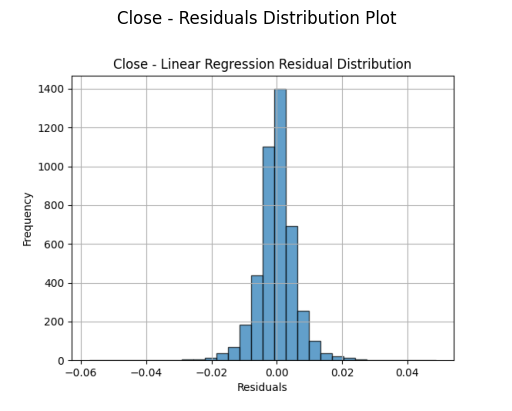


LinearRegression rmse for Open :  [0.00398221 0.00428666 0.00411321 0.0043355  0.00401449]
Avg. rmse:  0.00414641403666015 



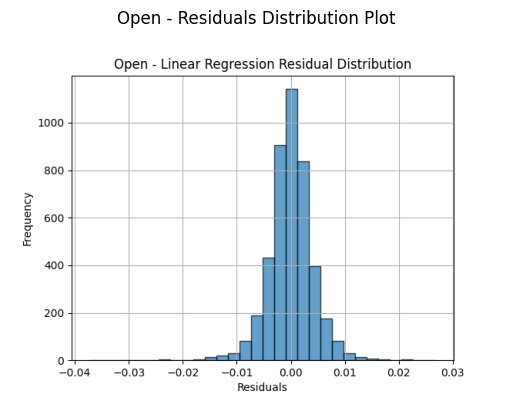


LinearRegression rmse for High :  [0.00550632 0.00608031 0.00632845 0.00577486 0.00568606]
Avg. rmse:  0.005875199537391391 



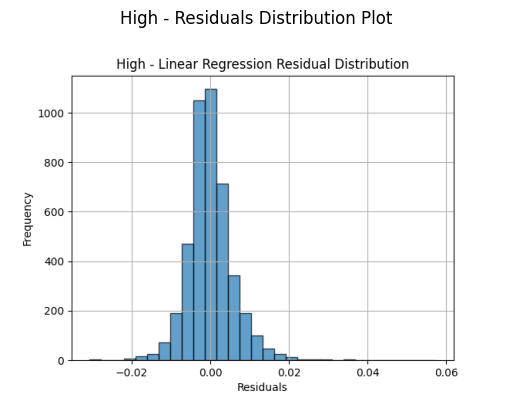


LinearRegression rmse for Low :  [0.00541459 0.00561616 0.00554073 0.00577218 0.00539974]
Avg. rmse:  0.005548680195510587 



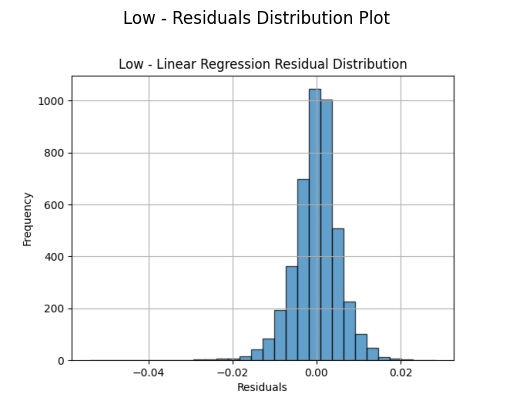

In [38]:
print('\n____________ K-fold cross validation ____________')
cv = KFold(n_splits=5, shuffle=True, random_state=37)  # cv data generator

run_new_evaluation = 0  # Set to 1 for new evaluation; 0 to load results
filename_prefix = "your_prefix"  # Change this to your desired prefix

if run_new_evaluation:
    for target in targets:
        # Evaluate Linear Regression
        model_name = "LinearRegression"
        model = LinearRegression()
        
        # Using one of the targets (for example, y_train_dict[target])
        y_train = y_train_dict[target]
        
        nmse_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
        rmse_scores = np.sqrt(-nmse_scores)
        
        # Save RMSE scores
        joblib.dump(rmse_scores, f'saved_objects/{model_name}_rmse_{target}.pkl')
        print(f"{target} - LinearRegression rmse: ", rmse_scores)
        print(f"{target} - Avg. rmse: ", mean(rmse_scores), '\n')

        # Step 2: Predict using cross-validation
        y_train_pred = cross_val_predict(model, X_train, y_train, cv=cv)
        
        # Step 3: Calculate residuals
        residuals = y_train - y_train_pred
        
        # Step 4: Plot the residual distribution
        plt.figure()
        plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
        plt.title(f'{target} - Linear Regression Residual Distribution')
        plt.xlabel('Residuals')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.savefig(f'models/{filename_prefix}_{target}_residuals_plot.png')  # Save with target name
        plt.close()  # Close the plot to free memory
else: 
    # Load LinearRegression RMSE
    for target in targets:
        model_name = "LinearRegression" 
        rmse_scores = joblib.load(f'saved_objects/{model_name}_rmse_{target}.pkl')
        print("\nLinearRegression rmse for", target, ": ", rmse_scores)
        print("Avg. rmse: ", mean(rmse_scores), '\n')

        # Load and show the residual distribution plot
        img = plt.imread(f'models/{filename_prefix}_{target}_residuals_plot.png')
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'{target} - Residuals Distribution Plot')
        plt.show()
